# Heart Attack Dataset - Exploratory Data Analysis
- Dataset path: `data/heart_attack_base.csv`


### Import and Theme Setting

In [ ]:
# Imports and settings
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

DATA_PATH = '../../data/base.csv'
TARGET_COL = 'target'

def detect_column_types(df: pd.DataFrame, target_col: str | None = None, cat_max_unique: int = 10):
    cont_cols = []
    cat_cols = []
    for col in df.columns:
        if col == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            # if numeric but low unique count -> treat as categorical variable
            if df[col].nunique(dropna=True) <= cat_max_unique:
                cat_cols.append(col)
            else:
                cont_cols.append(col)
        else:
            cat_cols.append(col)
    return cont_cols, cat_cols

### Dataset Overview


In [2]:
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
df.head()

AssertionError: File not found: ../../data/heart_attack_base.csv

### Missing Value and Duplicated Check


In [ ]:
# Missing values and duplicates overview
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percentages = (missing_counts / len(df) * 100).round(2)
missing_table = pd.DataFrame({'missing_count': missing_counts, 'missing_percentage': missing_percentages})

print("=== Table of Missing Values per Column ===")
if missing_table['missing_count'].sum() > 0:
    display(missing_table[missing_table['missing_count'] > 0])
else:
    print("No missing values found.\n")


# Print all duplicated rows (all copies)
num_duplicates = df.duplicated().sum()
print("=== Duplicate Rows ===")
print(f"Duplicate rows: {num_duplicates}")

dupes_all = df[df.duplicated(keep=False)]
if dupes_all.shape[0] > 0:
    display(dupes_all)


=== Table of Missing Values per Column ===
No missing values found.

=== Duplicate Rows ===
Duplicate rows: 272


,age,sex,Chest pain type,trestbps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
663,49,0,2,110,208,0,0,160,0,0.0,1,0
736,49,0,2,110,208,0,0,160,0,0.0,1,0
1129,58,1,3,150,219,0,1,118,1,0.0,2,1
1177,58,1,3,150,219,0,1,118,1,0.0,2,1
1190,70,1,4,130,322,0,2,109,0,2.4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1729,42,1,3,130,180,0,0,150,0,0.0,1,0
1730,61,1,4,140,207,0,2,138,1,1.9,1,1
1731,66,1,4,160,228,0,2,138,0,2.3,1,0
1732,46,1,4,140,311,0,0,120,1,1.8,2,1


### Column Types Detection


In [ ]:
print("Columns:", list(df.columns))

continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)

# Exclude target column 
if TARGET_COL in categorical_cols:
    categorical_cols = [c for c in categorical_cols if c != TARGET_COL]

# In Kaggle dataset, there are 'ca' column which is categorical but treated as numeric
if 'ca' in categorical_cols:
    categorical_cols.remove('ca')
    continuous_cols.append('ca')

print("\nContinuous columns:", continuous_cols)
print("Categorical columns:", categorical_cols)

df.dtypes

Columns: ['age', 'sex', 'Chest pain type', 'trestbps', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target']

Continuous columns: ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
Categorical columns: ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']


age                      int64
sex                      int64
Chest pain type          int64
trestbps                 int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

### Descriptive Statistics for Continuous Variables


In [ ]:
# Descriptive statistics for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns detected.")
else:
    desc = df[continuous_cols].describe().T
    # add additional stats
    desc['median'] = df[continuous_cols].median()
    desc['std'] = df[continuous_cols].std()
    desc = desc.rename(columns={'25%': 'q1', '50%': 'q2', '75%': 'q3'})
    display(desc[['count', 'mean', 'median', 'std', 'min', 'q1', 'q2', 'q3', 'max']])


,count,mean,median,std,min,q1,q2,q3,max
age,1763.0,53.952921,55.0,9.267101,28.0,47.0,55.0,61.0,77.0
trestbps,1763.0,131.950085,130.0,18.154333,0.0,120.0,130.0,140.0,200.0
cholesterol,1763.0,222.625638,234.0,90.119674,0.0,199.0,234.0,272.5,603.0
max heart rate,1763.0,142.952921,145.0,25.150727,60.0,125.0,145.0,162.0,202.0
oldpeak,1763.0,0.962337,0.6,1.109458,-2.6,0.0,0.6,1.6,6.2


### Histograms and KDE for Continuous Variables
- **What:** Shows the distribution of each continuous feature with histograms and KDEs
- **Why:** Understand distributional shape also helps interpret boxplot outliers and later model residuals

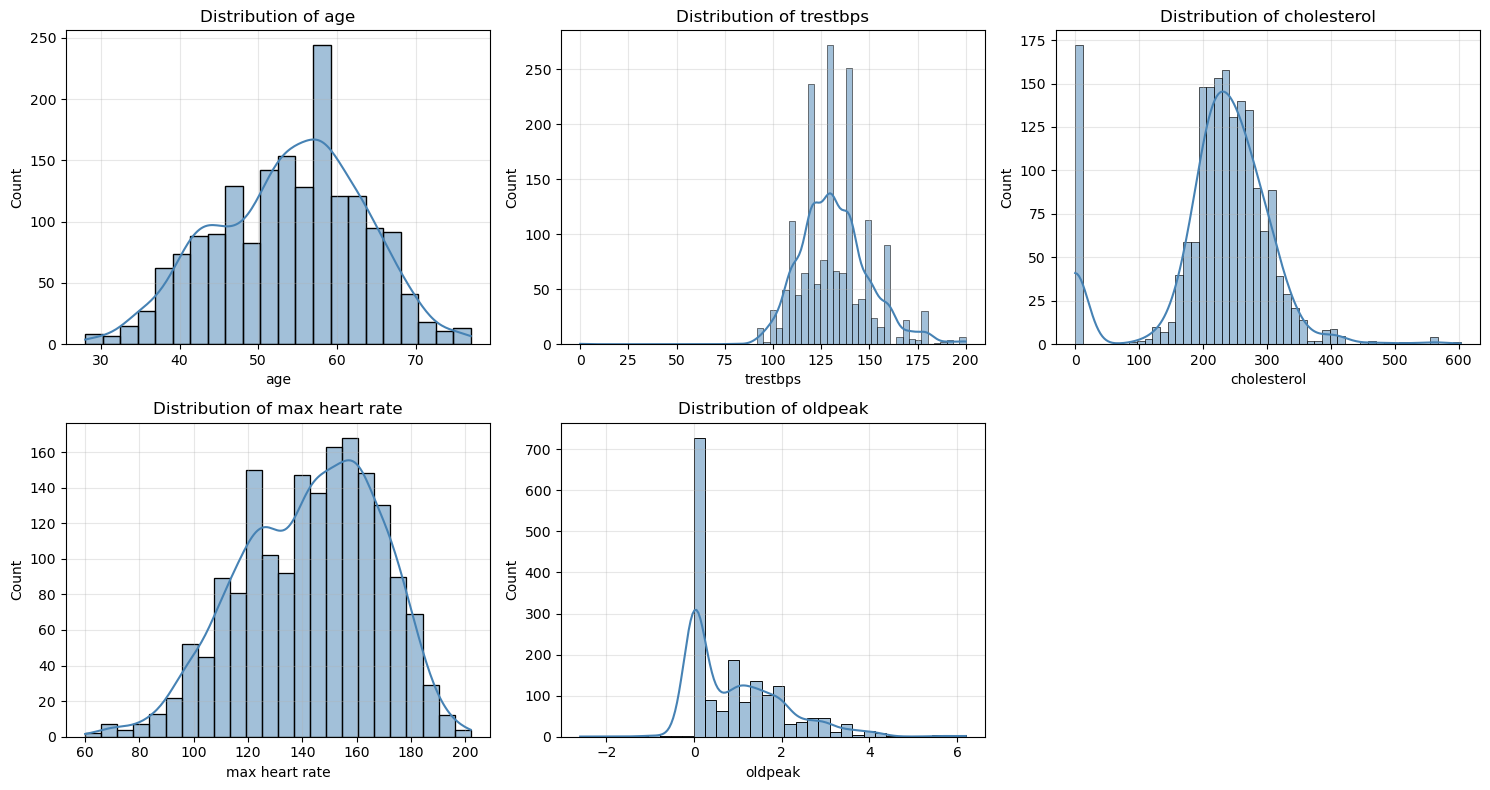

In [ ]:
# Histograms and KDE for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns to plot.")
else:
    n = len(continuous_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(continuous_cols):
        ax = axes[i]
        sns.histplot(data=df, x=col, ax=ax, stat="count", color="steelblue", edgecolor="black", kde=True)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.grid(True, alpha=0.3)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### Frequency Tables for Categorical Variables


In [ ]:
# Frequency tables for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns detected.")
else:
    for col in categorical_cols + ([TARGET_COL] if TARGET_COL in df.columns else []):
        print(f"\n=== {col} ===")
        _vc = df[col].value_counts(dropna=False).sort_index()
        _table_df = _vc.rename_axis(col).reset_index(name='count')
        _table_df['percent'] = (_table_df['count'] / _table_df['count'].sum() * 100).round(2)
        _table = _table_df.style.hide(axis='index').format({'percent': '{:.2f}%'})
        display(_table)



=== sex ===


sex,count,percent
0,465,26.38%
1,1298,73.62%



=== Chest pain type ===


Chest pain type,count,percent
0,23,1.30%
1,136,7.71%
2,344,19.51%
3,506,28.70%
4,754,42.77%



=== fasting blood sugar ===


fasting blood sugar,count,percent
0,1424,80.77%
1,339,19.23%



=== resting ecg ===


resting ecg,count,percent
0,966,54.79%
1,187,10.61%
2,610,34.60%



=== exercise angina ===


exercise angina,count,percent
0,1114,63.19%
1,649,36.81%



=== ST slope ===


ST slope,count,percent
0,143,8.11%
1,796,45.15%
2,725,41.12%
3,99,5.62%



=== target ===


target,count,percent
0,725,41.12%
1,918,52.07%
2,120,6.81%


### Bar Charts for Categorical Variables


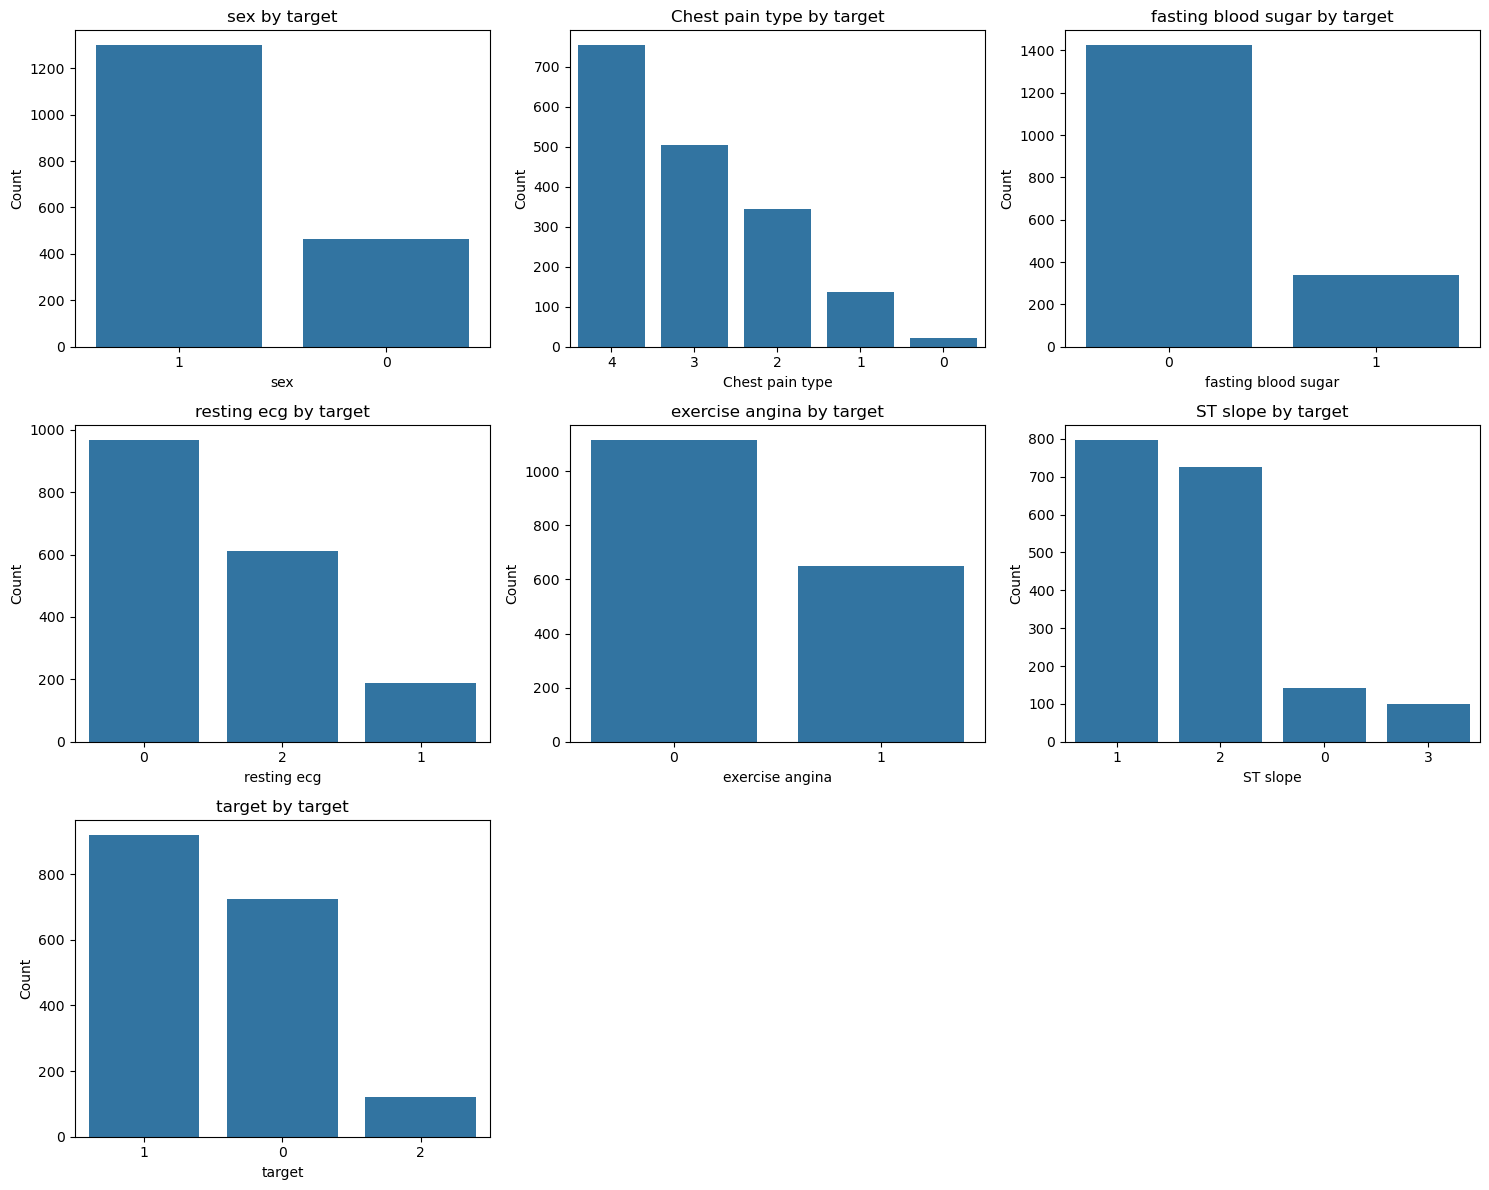

In [ ]:
# Bar charts for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns to plot.")
else:
    cat_to_plot = categorical_cols + [TARGET_COL]
    
    n = len(cat_to_plot)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(cat_to_plot):
        ax = axes[i]
        order = df[col].value_counts().index  # order by frequency
        sns.countplot(data=df, x=col, order=order, ax=ax)
        ax.set_title(f"{col} by {TARGET_COL}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.grid(False)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Data Quality Summary
- **Result on Quality**:
  - `CLEAN_ENOUGH`: Proceed to modeling; keep monitoring during validation.
  - `MOSTLY_CLEAN_WITH_OUTLIERS`: Consider capping/winsorizing or robust scalers; tree-based models are less sensitive.
  - `NEEDS_ATTENTION`: Address missing/duplicates/implausible ranges before modeling.


In [ ]:
summary = {}

# Missing and duplicates
missing_counts = df.isna().sum()
summary['missing_total'] = int(missing_counts.sum())
summary['missing_columns'] = {c: int(missing_counts[c]) for c in df.columns if missing_counts[c] > 0}
summary['duplicates'] = int(df.duplicated().sum())

# Type detection
continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)
summary['continuous_cols'] = continuous_cols
summary['categorical_cols'] = categorical_cols

# Plausibility checks
plausible_flags = []
if 'age' in df.columns:
    plausible_flags.append(df['age'].between(18, 100, inclusive='both').all())
if 'trestbps' in df.columns:
    plausible_flags.append((df['trestbps'] > 0).all())
if 'cholesterol' in df.columns:
    plausible_flags.append((df['cholesterol'] > 0).all())
if 'max heart rate' in df.columns:
    plausible_flags.append((df['max heart rate'] > 0).all())
summary['plausible_ranges_pass'] = all(plausible_flags) if plausible_flags else None

# Outlier rate
outlier_rates = {}
for col in continuous_cols:
    s = df[col].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    rate = float(((s < lower) | (s > upper)).mean())
    outlier_rates[col] = round(rate, 4)
summary['outlier_rates'] = outlier_rates

# Target balance
if TARGET_COL in df.columns:
    vc = df[TARGET_COL].value_counts(normalize=True)
    summary['target_balance'] = {int(k): round(float(v), 4) for k, v in vc.items()}

# Overall verdict
def verdict_from_summary(s):
    if s['missing_total'] == 0 and s['duplicates'] == 0 and (s['plausible_ranges_pass'] in [True, None]):
        # outliers allowed if low or clinically plausible
        hi_outliers = [c for c, r in s['outlier_rates'].items() if r > 0.1]
        if len(hi_outliers) == 0:
            return 'CLEAN_ENOUGH'
        return 'CONTAINING_[OUTLIERS = {s["outlier_rates"]}]'
    return f'CONTAINING_[MISSING = {s["missing_total"]} | DUPLICATES = {s["duplicates"]} | PLAUSIBLE_RANGES_PASS = {s["plausible_ranges_pass"]}]'
summary['verdict'] = verdict_from_summary(summary)

print('Data Quality Summary:')
for k, v in summary.items():
    print(f"- {k}: {v}")

Data Quality Summary:
- missing_total: 0
- missing_columns: {}
- duplicates: 272
- continuous_cols: ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
- categorical_cols: ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']
- plausible_ranges_pass: False
- outlier_rates: {'age': 0.0, 'trestbps': 0.0312, 'cholesterol': 0.118, 'max heart rate': 0.0023, 'oldpeak': 0.0113}
- target_balance: {1: 0.5207, 0: 0.4112, 2: 0.0681}
- verdict: CONTAINING_[MISSING = 0 | DUPLICATES = 272 | PLAUSIBLE_RANGES_PASS = False]


#### Detect and Display Plausibility Violations

In [ ]:
# check plausibility violations
viol_masks = {
  "age_out_of_range": ~df["age"].between(18, 100, inclusive="both"),
  "trestbps_nonpositive": df["trestbps"] <= 0,
  "cholesterol_nonpositive": df["cholesterol"] <= 0,
  "oldpeak_negative": df["oldpeak"] < 0,
  "max_hr_nonpositive": df["max heart rate"] <= 0,
}

counts = {k: int(m.sum()) for k, m in viol_masks.items()}
print(counts)

def show_examples(mask, cols, n=10):
  subset = df.loc[mask, cols].copy()
  subset.insert(0, "csv_line", subset.index + 2)
  return subset.head(n)

cols = ["age", "trestbps", "cholesterol", "oldpeak", "max heart rate"]

if viol_masks["trestbps_nonpositive"].sum() > 0:
    print("\n=== trestbps_nonpositive ===")
    display(show_examples(viol_masks["trestbps_nonpositive"], cols))

if viol_masks["cholesterol_nonpositive"].sum() > 0:
    print("\n=== cholesterol_nonpositive ===")
    display(show_examples(viol_masks["cholesterol_nonpositive"], cols))

if viol_masks["oldpeak_negative"].sum() > 0:
    print("\n=== oldpeak_negative ===")
    display(show_examples(viol_masks["oldpeak_negative"], cols))

{'age_out_of_range': 0, 'trestbps_nonpositive': 1, 'cholesterol_nonpositive': 172, 'oldpeak_negative': 13, 'max_hr_nonpositive': 0}

=== trestbps_nonpositive ===


,csv_line,age,trestbps,cholesterol,oldpeak,max heart rate
1023,1025,55,0,0,1.5,155



=== cholesterol_nonpositive ===


,csv_line,age,trestbps,cholesterol,oldpeak,max heart rate
867,869,65,115,0,0.0,93
868,870,32,95,0,0.7,127
869,871,61,105,0,1.5,110
870,872,50,145,0,0.7,139
871,873,57,110,0,1.4,131
872,874,51,110,0,0.0,92
873,875,47,110,0,2.1,149
874,876,60,160,0,0.4,149
875,877,55,140,0,0.2,150
876,878,53,125,0,1.5,120



=== oldpeak_negative ===


,csv_line,age,trestbps,cholesterol,oldpeak,max heart rate
895,897,63,100,0,-0.9,109
898,900,46,100,0,-2.6,133
899,901,42,105,0,-1.5,128
900,902,45,110,0,-0.1,138
905,907,56,115,0,-1.0,82
906,908,38,100,0,-1.1,179
908,910,51,130,0,-0.7,170
909,911,62,120,0,-0.8,134
926,928,56,120,0,-1.0,100
981,983,62,115,0,-0.5,72


### Boxplots for Continuous Varaibles


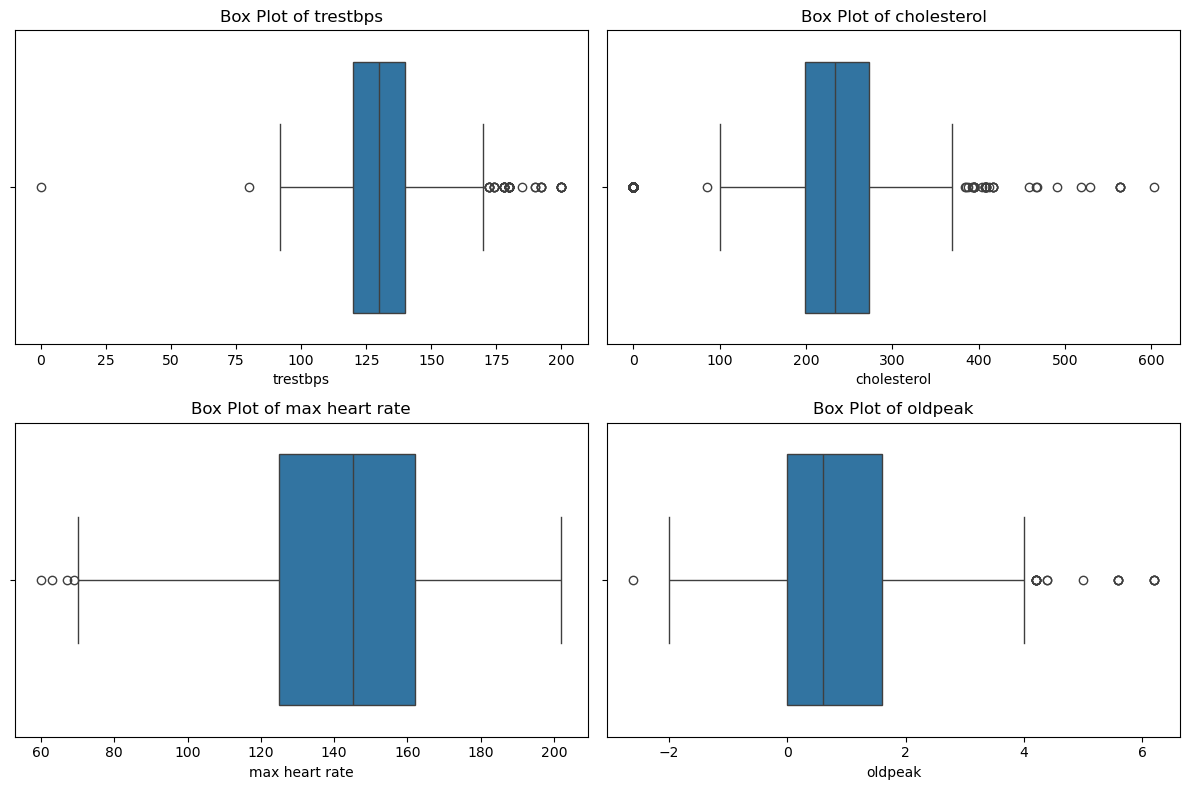

In [ ]:
# Boxplots by target (e.g., cholesterol vs target)
if TARGET_COL in df.columns and TARGET_COL in df.select_dtypes(include=[np.number]).columns and df[TARGET_COL].nunique() <= 10:
    if len(continuous_cols) == 0:
        print("No continuous columns to plot.")
    else:
        
        con_to_plot = continuous_cols.copy();
        con_to_plot.remove("age");
        
        n = len(con_to_plot)
        ncols = 2
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
        axes = axes.flatten() if n > 1 else [axes]

        for i, col in enumerate(con_to_plot):
            ax = axes[i]
            sns.boxplot(data=df, x=col, ax=ax)
            ax.set_title(f"Box Plot of {col}")
            ax.set_xlabel(col)
            ax.grid(False)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Target column not suitable for grouping boxplots (missing/not numeric/too many classes).")


### IQR Outlier Summary

In [ ]:
# IQR-based outlier detection summary for continuous variables
def iqr_outlier_flags(series: pd.Series, k: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper), lower, upper

In [ ]:
if len(continuous_cols) == 0:
    print("No continuous columns for outlier analysis.")
else:
    rows = []
    for col in continuous_cols:
        flags, lower, upper = iqr_outlier_flags(df[col].dropna())
        outlier_count = int(flags.sum())
        rows.append({
            'column': col,
            'outliers': outlier_count,
            'outliers_pct': round(outlier_count / df[col].dropna().shape[0] * 100, 2),
            'lower_bound': round(lower, 2),
            'upper_bound': round(upper, 2)
        })
    outlier_table = pd.DataFrame(rows).sort_values('outliers', ascending=False)
    display(outlier_table)

,column,outliers,outliers_pct,lower_bound,upper_bound
2,cholesterol,208,11.80,88.75,382.75
1,trestbps,55,3.12,90.00,170.00
4,oldpeak,20,1.13,-2.40,4.00
3,max heart rate,4,0.23,69.50,217.50
0,age,0,0.00,26.00,82.00


### Correlation Matrix and Heatmap
- **What this does**: Computes the Pearson correlation among all numeric features and visualizes it as a heatmap. This reveals linear relationships between variables and with the `target` (if numeric/binary).
- **Why it matters**: Strong correlations with `target` highlight promising predictors for the modeling stage (feature selection/importance). High correlations between features indicate potential multicollinearity, guiding regularization (e.g., L1/L2), feature grouping, or dimensionality reduction before models like Logistic Regression.


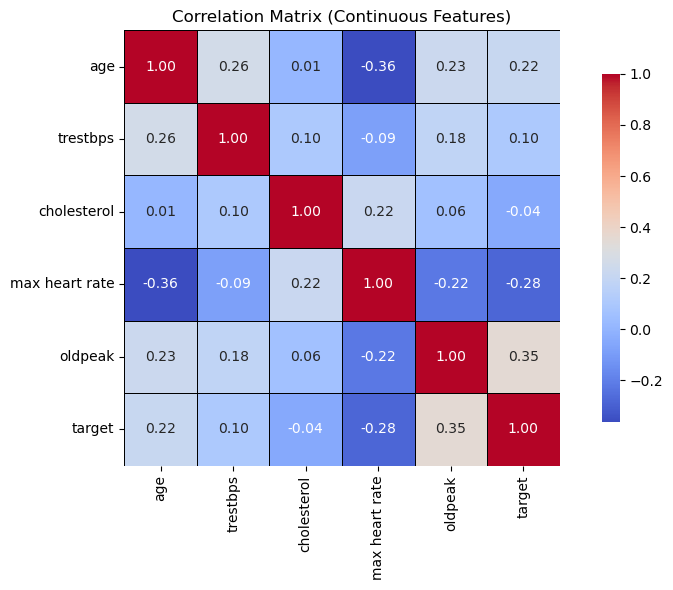

In [ ]:
# Correlation matrix and heatmap (continuous features only)
cont_df = df[continuous_cols + [TARGET_COL]]
if len(continuous_cols) <= 1:
    print("Not enough continuous columns for correlation analysis.")
else:
    corr = cont_df.corr(method="pearson")
    plt.figure(figsize=(9, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
                cbar_kws={'shrink': .8}, linewidths=0.5, linecolor='black')
    plt.title('Correlation Matrix (Continuous Features)')
    plt.tight_layout()
    plt.show()


### Scatter plots for categorical relationships colored by target
We visualize two pairs:
- Chest pain type vs ST slope, colored by target.
- Chest pain type vs exercise angina, colored by target.

Because these are categorical-coded integers, we apply light jitter and use swarm-like positioning for readability.


In [ ]:
def plot_scatter_by_target(df, cols_needed, jitter_strength=0.1):
    if not all(c in df.columns for c in cols_needed):
      print('Missing required columns:', [c for c in cols_needed if c not in df.columns])
    else:
        plot_df = df[cols_needed].dropna().copy()

        # Cast to category for clear ticks and labels (values are codes)
        plot_df[cols_needed[0]] = plot_df[cols_needed[0]].astype(int)
        plot_df[cols_needed[1]] = plot_df[cols_needed[1]].astype(int)

        # Jitter helper for categorical-coded integers
        rng = np.random.default_rng(42)
        jitter_strength = 0.13
        x_jitter = plot_df[cols_needed[0]] + rng.normal(0, jitter_strength, size=len(plot_df))
        y_jitter = plot_df[cols_needed[1]] + rng.normal(0, jitter_strength, size=len(plot_df))

        plt.figure(figsize=(7, 5))
        sns.scatterplot(x=x_jitter, y=y_jitter, hue=plot_df[TARGET_COL].astype(str), palette=['orange', 'red', 'steelblue'])
        plt.title(f'Scatter plot: {cols_needed[0]} vs {cols_needed[1]} \n(Colored by {TARGET_COL})')
        plt.xlabel(cols_needed[0])
        plt.ylabel(cols_needed[1])

        # Set integer tick locations and labels
        x_levels = sorted(df[cols_needed[0]].dropna().astype(int).unique())
        y_levels = sorted(df[cols_needed[1]].dropna().astype(int).unique())
        plt.xticks(ticks=x_levels, labels=[str(v) for v in x_levels])
        plt.yticks(ticks=y_levels, labels=[str(v) for v in y_levels])
        plt.legend(title='target')
        plt.tight_layout()
        plt.show()

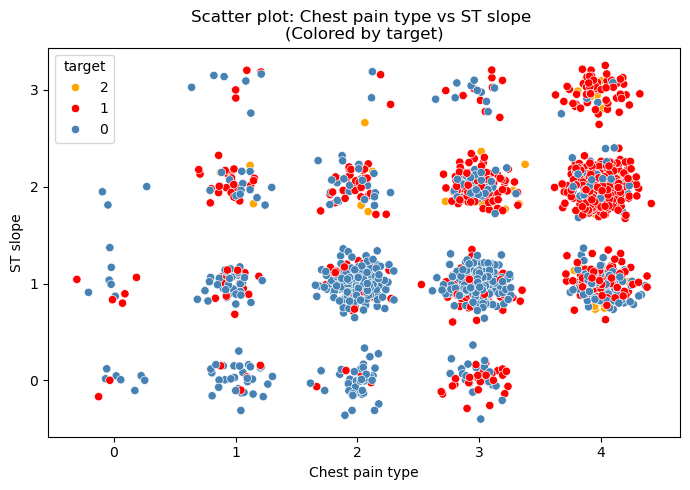

In [ ]:
plot_scatter_by_target(df, ['Chest pain type', 'ST slope', TARGET_COL], 0.13)

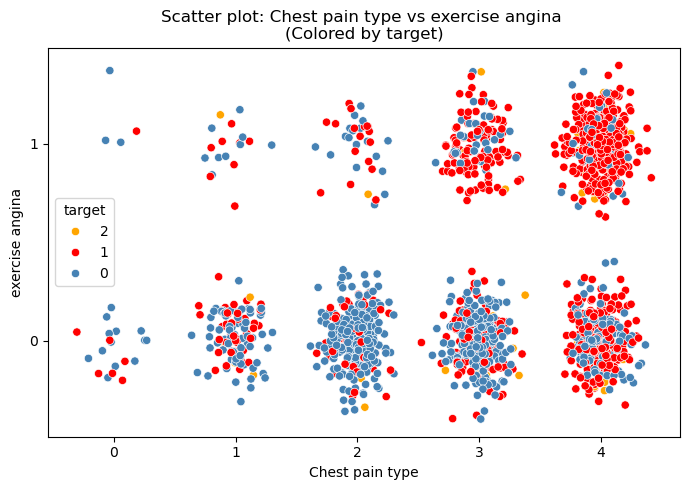

In [ ]:
plot_scatter_by_target(df, ['Chest pain type', 'exercise angina', TARGET_COL], 0.1)